Chapter 06

# 连续随机变量
Book_5《统计至简》 | 鸢尾花书：从加减乘除到机器学习 (第二版)

该代码主要用于对鸢尾花数据集中某些特征的联合分布和条件分布进行可视化分析。通过估计两个特征的联合概率密度函数（PDF） $f_{X_1, X_2}(x_1, x_2)$ 和条件概率密度函数 $f_{X_2 | X_1}(x_2 | x_1)$ 以及 $f_{X_1 | X_2}(x_1 | x_2)$，代码绘制出不同类别条件下的联合分布、边缘分布和条件分布。以下是具体步骤：

1. **数据准备**：加载鸢尾花数据集中的两个特征（萼片长度 $X_1$ 和萼片宽度 $X_2$）并将其用作随机变量 $X_1$ 和 $X_2$ 的观测值。

2. **联合分布 $f_{X_1, X_2}(x_1, x_2)$**：利用高斯核密度估计方法计算 $X_1$ 和 $X_2$ 的联合PDF并进行3D绘制。联合分布 $f_{X_1, X_2}$ 表示两个特征的联合出现概率。

3. **边缘分布 $f_{X_1}(x_1)$ 和 $f_{X_2}(x_2)$**：分别计算 $X_1$ 和 $X_2$ 的边缘分布，并通过从联合分布中积分 $f_{X_1, X_2}(x_1, x_2)$ 得到。边缘分布 $f_{X_1}(x_1) = \int f_{X_1, X_2}(x_1, x_2) \, dx_2$ 和 $f_{X_2}(x_2) = \int f_{X_1, X_2}(x_1, x_2) \, dx_1$。

4. **条件分布 $f_{X_2 | X_1}(x_2 | x_1)$ 和 $f_{X_1 | X_2}(x_1 | x_2)$**：利用联合分布计算条件分布，例如 $f_{X_2 | X_1}(x_2 | x_1) = \frac{f_{X_1, X_2}(x_1, x_2)}{f_{X_1}(x_1)}$。条件分布表示在给定某一特征值时，另一特征的可能值范围。

5. **类别条件分布**：对数据集的不同类别（例如，类别 $C_1$、$C_2$、$C_3$）分别计算联合分布和边缘分布，用于研究不同类别下的特征行为。

该代码不仅展示了分布的3D可视化，还使用等高线图和散点图帮助直观地理解特征间的关系，展示了随机变量的独立性和相关性在各类条件下的不同表现。

In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import pandas as pd  
from sklearn.datasets import load_iris
import scipy.stats as st
from matplotlib import cm

## 可视化函数

## 使用3D和2D可视化表面

In [2]:
def plot_surface(xx1, xx2, surface, z_height, title_txt):

    fig = plt.figure(figsize=plt.figaspect(0.5))
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    
    ax.plot_wireframe(xx1, xx2, surface, color = [0.7,0.7,0.7], linewidth = 0.25)
    
    ax.contour3D(xx1, xx2, surface, 20, cmap = 'RdYlBu_r')
    
    ax.set_proj_type('ortho')
    
    ax.set_xlabel('Sepal length, $x_1$') # 设置X轴标签
    ax.set_ylabel('Sepal width, $x_2$')  # 设置Y轴标签
    ax.set_zlabel('PDF')  # 设置Z轴标签
    # ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置背景颜色
    # ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置背景颜色
    # ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置背景颜色
    ax.set_xticks([4,5,6,7,8]) # 设置X轴刻度
    ax.set_yticks([1,2,3,4,5]) # 设置Y轴刻度
    ax.set_xlim(x1.min(), x1.max()) # 设置X轴范围
    ax.set_ylim(x2.min(), x2.max()) # 设置Y轴范围
    ax.set_zlim3d([0,z_height]) # 设置Z轴范围
    ax.view_init(azim=-120, elev=30) # 设置视角
    ax.set_title(title_txt) # 设置标题
    ax.grid(False)

    
    ax = fig.add_subplot(1, 2, 2)
    
    # 绘制等高线
    cset = ax.contour(xx1, xx2, surface, 20, cmap='RdYlBu_r')
    ax.set_xticks([4,5,6,7,8]) # 设置X轴刻度
    ax.set_yticks([1,2,3,4,5]) # 设置Y轴刻度
    ax.set_xlim(x1.min(), x1.max()) # 设置X轴范围
    ax.set_ylim(x2.min(), x2.max()) # 设置Y轴范围
    ax.set_xlabel('Sepal length, $x_1$') # 设置X轴标签
    ax.set_ylabel('Sepal width, $x_2$')  # 设置Y轴标签
    plt.gca().set_aspect('equal', adjustable='box') # 设置比例
    ax.set_title(title_txt) # 设置标题
    plt.show()

## 可视化2D PDF等高线和边缘分布

In [3]:
import matplotlib.gridspec as gridspec

def plot_joint_marginal(xx1,xx2,surface,
                        x1,f_x1,
                        x2,f_x2,
                        x1_s,x2_s,
                        color,title_txt):
    
    fig = plt.figure(figsize=(7, 7))
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[3, 1])
    
    # 绘制表面图
    ax1 = plt.subplot(gs[0])
    
    ax1.contour(xx1,xx2,surface, 20, cmap='RdYlBu_r') # 绘制等高线
    ax1.scatter(x1_s, x2_s, c=color) # 绘制数据点
    
    ax1.set_xlabel('Sepal length, $x_1$') # 设置X轴标签
    ax1.set_ylabel('Sepal width, $x_2$')  # 设置Y轴标签
    ax1.yaxis.set_label_position('right') # 设置Y轴标签位置
    ax1.set_xticks([]) # 隐藏X轴刻度
    ax1.set_yticks([]) # 隐藏Y轴刻度
    ax1.set_title(title_txt) # 设置标题
    
    # 绘制Y的边缘分布
    ax2 = plt.subplot(gs[1])
    
    ax2.plot(f_x2, x2, color = color) # 绘制Y的PDF曲线
    
    ax2.fill_between(f_x2, x2, edgecolor = 'none', facecolor = color, alpha = 0.2) # 填充PDF曲线
    
    ax2.set_xlabel('PDF') # 设置X轴标签
    ax2.set_ylim(1, 5) # 设置Y轴范围
    ax2.set_xlim(0, 1.5) # 设置X轴范围
    ax2.set_xticks([0, 0.5, 1, 1.5]) # 设置X轴刻度
    ax2.set_yticks([1,2,3,4,5]) # 设置Y轴刻度
    ax2.invert_xaxis() # 反转X轴
    ax2.yaxis.tick_right() # 设置Y轴刻度在右侧
    
    # 绘制X的边缘分布
    ax3 = plt.subplot(gs[2])
    
    ax3.plot(x1, f_x1, color = color) # 绘制X的PDF曲线
    
    ax3.fill_between(x1, f_x1, edgecolor = 'none', facecolor = color, alpha = 0.2) # 填充PDF曲线
    
    ax3.set_ylabel('PDF') # 设置Y轴标签
    ax3.yaxis.set_label_position('left') # 设置Y轴标签位置
    ax3.set_xlim(4,8) # 设置X轴范围
    ax3.set_xticks([4,5,6,7,8]) # 设置X轴刻度
    ax3.set_ylim(0, 1.5) # 设置Y轴范围
    ax3.set_yticks([0, 0.5, 1, 1.5]) # 设置Y轴刻度
    ax4 = plt.subplot(gs[3])
    ax4.set_visible(False)
    
    plt.show()

## 数据准备

In [4]:
iris = load_iris() # 加载iris数据集

X_1_to_4 = iris.data # 获取特征数据
y = iris.target # 获取目标数据

feature_names = ['Sepal length, $X_1$','Sepal width, $X_2$','Petal length, $X_3$','Petal width, $X_4$'] # 设置特征名称

In [5]:
X_df = pd.DataFrame(X_1_to_4, columns=feature_names) # 创建特征数据的DataFrame
y_df = pd.DataFrame(y, columns=['label']) # 创建目标数据的DataFrame

In [6]:
y_df[y_df==0] = 'C_1' # 将标签为0的转换为C_1
y_df[y_df==1] = 'C_2' # 将标签为1的转换为C_2
y_df[y_df==2] = 'C_3' # 将标签为2的转换为C_3

C:\Users\james\AppData\Local\Temp\ipykernel_2948\30537425.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'C_1' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  y_df[y_df==0] = 'C_1' # 将标签为0的转换为C_1


In [7]:
X1_2_df = X_df[['Sepal length, $X_1$','Sepal width, $X_2$']] # 提取X1和X2的特征数据

In [8]:
x1 = np.linspace(4,8,161) # 设置x1的范围
x2 = np.linspace(1,5,161) # 设置x2的范围

In [9]:
xx1, xx2 = np.meshgrid(x1,x2) # 创建网格
positions = np.vstack([xx1.ravel(), xx2.ravel()]) # 将网格拉直

## 绘制联合PDF，没有标签

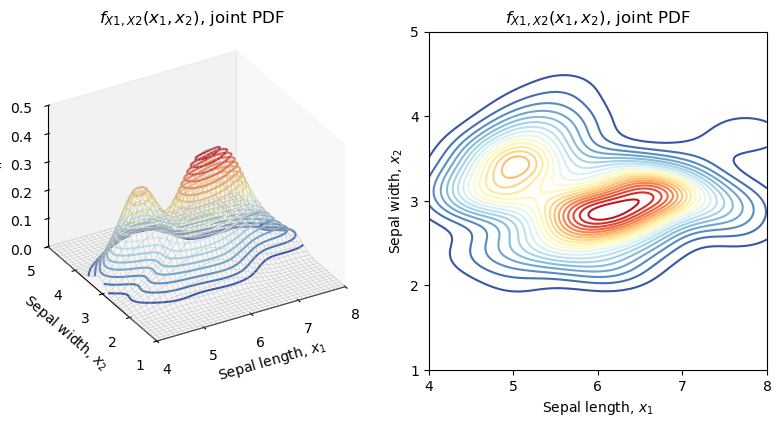

In [10]:
kernel = st.gaussian_kde(X1_2_df.values.T) # 计算联合概率密度
f_x1_x2_SM = np.reshape(kernel(positions).T, xx1.shape) # 将联合概率密度数据重新整形

z_height = 0.5 # 设置Z轴高度
title_txt = '$f_{X1, X2}(x_1, x_2)$, joint PDF' # 设置标题
plot_surface(xx1, xx2, f_x1_x2_SM, z_height, title_txt) # 绘制联合PDF的表面图

## 在特定的X1位置处绘制联合PDF

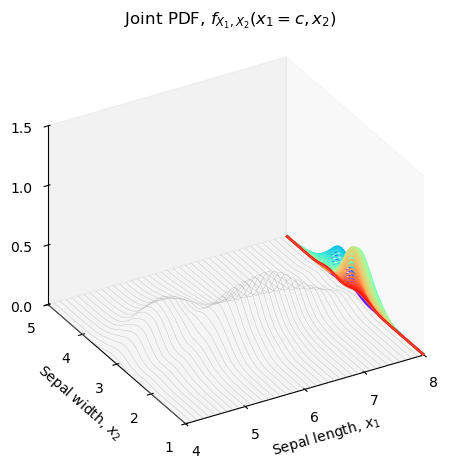

In [11]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}) # 创建3D图形对象

ax.plot_wireframe(xx1, xx2, f_x1_x2_SM, color = [0.7,0.7,0.7], linewidth = 0.25, rstride=0, cstride=4) # 绘制网格线框
ax.contour(xx1, xx2, f_x1_x2_SM, levels = 40, zdir='x', offset= xx1.max(), cmap='rainbow') # 绘制等高线图

ax.set_proj_type('ortho') # 设置投影类型为正交投影
ax.set_xlabel('Sepal length, $x_1$') # 设置X轴标签
ax.set_ylabel('Sepal width, $x_2$') # 设置Y轴标签
ax.set_title('Joint PDF, $f_{X_1,X_2}(x_1 = c,x_2)$') # 设置标题
# ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置背景颜色
# ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置背景颜色
# ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置背景颜色
ax.set_xticks([4,5,6,7,8]) # 设置X轴刻度
ax.set_yticks([1,2,3,4,5]) # 设置Y轴刻度
ax.set_zticks([0, 0.5, 1.0, 1.5]) # 设置Z轴刻度
ax.set_xlim(x1.min(), x1.max()) # 设置X轴范围
ax.set_ylim(x2.min(), x2.max()) # 设置Y轴范围
ax.set_zlim3d([0,1.5]) # 设置Z轴范围
ax.view_init(azim=-120, elev=30) # 设置视角
plt.tight_layout() # 调整布局
ax.grid(False) # 隐藏网格线
plt.show() # 显示图形

## 下采样表面上的投影

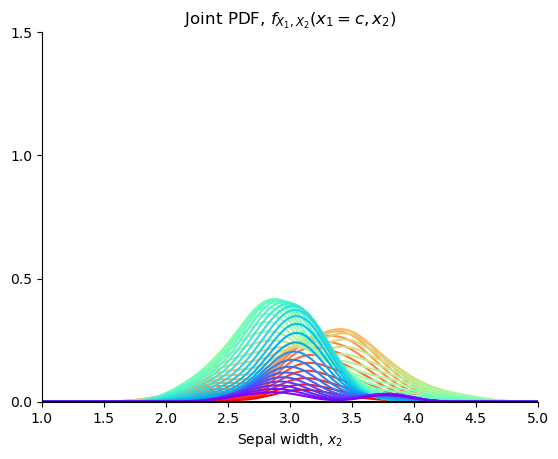

In [12]:
down_step = 4 # 设置下采样步长
array_downsample = x1[0::down_step] # 对x1进行下采样

fig, ax = plt.subplots() # 创建2D图形对象

colors = plt.cm.rainbow_r(np.linspace(0,1,len(array_downsample))) # 设置颜色

for i in np.linspace(1,len(array_downsample),len(array_downsample)): # 遍历下采样后的数组
    plt.plot(x2, f_x1_x2_SM[:,(int(i)-1)*down_step], color = colors[int(i)-1]) # 绘制PDF曲线

plt.axhline(y=0, color='k', linestyle='-') # 添加X轴水平线
ax.spines['right'].set_visible(False) # 隐藏右侧边框
ax.spines['top'].set_visible(False) # 隐藏顶部边框
ax.set_xlabel('Sepal width, $x_2$') # 设置X轴标签
ax.set_title('Joint PDF, $f_{X_1,X_2}(x_1 = c,x_2)$') # 设置标题
ax.set_xlim(xx2.min(), xx2.max()) # 设置X轴范围
ax.set_ylim(0,1.5) # 设置Y轴范围
ax.set_yticks([0, 0.5, 1.0, 1.5]) # 设置Y轴刻度

## 边缘分布 X1

In [13]:
X1_df = X_df['Sepal length, $X_1$'] # 提取X1的数据

KDE_X1 = sm.nonparametric.KDEUnivariate(X1_df) # 创建X1的核密度估计对象
KDE_X1.fit(bw=0.1) # 设置核密度估计的带宽

f_x1_marginal = KDE_X1.evaluate(x1) # 计算X1的边缘分布

## 绘制边缘分布理解的工具

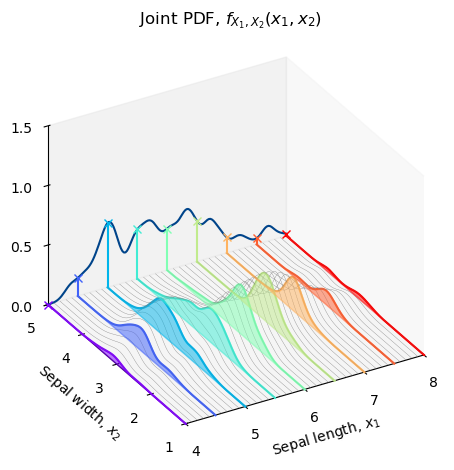

In [14]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}) # 创建3D图形对象

ax.plot_wireframe(xx1, xx2, f_x1_x2_SM, color = [0.5,0.5,0.5], rstride=0, cstride=4, linewidth = 0.25) # 绘制网格线框

ax.set_proj_type('ortho') # 设置投影类型为正交投影

ax.set_xlabel('Sepal length, $x_1$') # 设置X轴标签
ax.set_ylabel('Sepal width, $x_2$') # 设置Y轴标签
ax.set_title('Joint PDF, $f_{X_1,X_2}(x_1,x_2)$') # 设置标题
ax.set_xticks([4,5,6,7,8]) # 设置X轴刻度
ax.set_yticks([1,2,3,4,5]) # 设置Y轴刻度
ax.set_zticks([0, 0.5, 1.0, 1.5]) # 设置Z轴刻度
ax.set_xlim(xx1.min(), xx1.max()) # 设置X轴范围
ax.set_ylim(xx2.min(), xx2.max()) # 设置Y轴范围
ax.set_zlim3d([0,1.5]) # 设置Z轴范围
ax.view_init(azim=-120, elev=30) # 设置视角
plt.tight_layout() # 调整布局
ax.grid(False) # 隐藏网格线


x_loc_array = np.arange(0, len(x1), 20) # 设置x1的采样位置
facecolors = cm.rainbow(np.linspace(0, 1, len(x_loc_array))) # 设置颜色

for idx in range(len(x_loc_array)): # 遍历采样位置
    x_loc = x_loc_array[idx] # 获取当前x位置
    x_idx = x1[x_loc] # 获取当前x的值
    x_i_array = x2 * 0 + x_idx # 设置X轴数组
    z_array = f_x1_x2_SM[:, x_loc] # 获取Z轴数组
    
    ax.plot(x_i_array, x2, z_array, color=facecolors[idx, :], linewidth=1.5) # 绘制当前x位置的PDF曲线
    ax.add_collection3d(plt.fill_between(x2, 0 * z_array, z_array, color=facecolors[idx, :], alpha=0.3), zs=x_idx, zdir='x') # 填充PDF曲线区域

# 添加X1上的边缘分布

ax.plot(x1, x1 * 0 + 5, f_x1_marginal, linewidth=1.5, color='#00448A') # 绘制X1的边缘分布曲线

for i in range(len(x_loc_array)): # 遍历采样位置
    
    x_loc = x_loc_array[i] # 获取当前x位置
    x_idx = x1[x_loc] # 获取当前x的值
    
    ax.plot([x_idx, x_idx], [x2.max(), x2.max()], [0, f_x1_marginal[x_loc]], color=facecolors[i, :], linewidth=1.5) # 绘制边缘分布的垂直线
    ax.plot(x_idx, x2.max(), f_x1_marginal[x_loc], marker='x', color=facecolors[i, :]) # 绘制边缘分布的标记点

## 条件PDF计算与绘制

In [15]:
delta_x = 4 / 160 # 设置X轴的间隔，用于条件PDF的归一化

# 计算条件PDF矩阵，表示在给定X1情况下X2的条件概率密度
conditional_X2_given_X1_matrix = f_x1_x2_SM / (np.ones((161, 1)) @ np.array([f_x1_x2_SM.sum(axis=0)]) * delta_x)

# 计算条件PDF矩阵在X2上的部分积分
partial_integral_over_x2 = conditional_X2_given_X1_matrix.sum(axis=0) * delta_x
# print(partial_integral_over_x2) # 输出部分积分结果，用于验证归一化

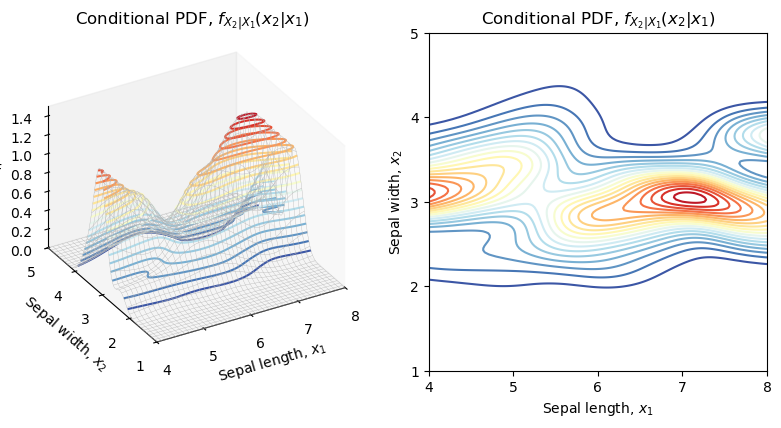

In [16]:
z_height = 1.5 # 设置Z轴的高度范围
title_txt = 'Conditional PDF, $f_{X_2 | X_1}(x_2 | x_1)$' # 设置图形标题
plot_surface(xx1, xx2, conditional_X2_given_X1_matrix, z_height, title_txt) # 调用绘图函数绘制条件PDF

## 条件PDF的3D网格图

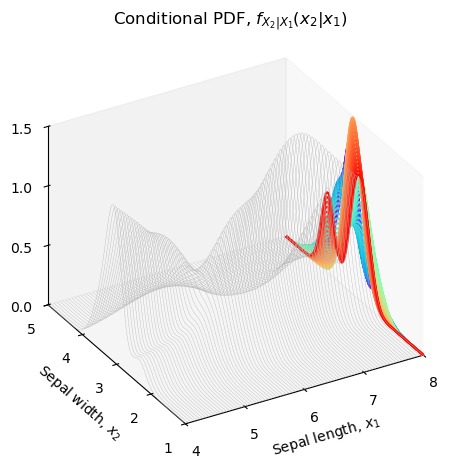

In [17]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}) # 创建3D图形对象

# 绘制条件PDF的网格线框图
ax.plot_wireframe(xx1, xx2, conditional_X2_given_X1_matrix, color=[0.7, 0.7, 0.7], linewidth=0.25, rstride=0, cstride=2)
ax.contour(xx1, xx2, conditional_X2_given_X1_matrix, levels=80, zdir='x', offset=xx1.max(), cmap='rainbow') # 绘制等高线图

ax.set_proj_type('ortho') # 设置正交投影

ax.set_xlabel('Sepal length, $x_1$') # 设置X轴标签
ax.set_ylabel('Sepal width, $x_2$') # 设置Y轴标签
ax.set_title('Conditional PDF, $f_{X_2 | X_1}(x_2 | x_1)$') # 设置图形标题
# ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置背景颜色
# ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置背景颜色
# ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置背景颜色
ax.set_xticks([4,5,6,7,8]) # 设置X轴刻度
ax.set_yticks([1,2,3,4,5]) # 设置Y轴刻度
ax.set_zticks([0, 0.5, 1.0, 1.5]) # 设置Z轴刻度
ax.set_xlim(x1.min(), x1.max()) # 设置X轴范围
ax.set_ylim(x2.min(), x2.max()) # 设置Y轴范围
ax.set_zlim3d([0, 1.5]) # 设置Z轴范围
ax.view_init(azim=-120, elev=30) # 设置视角
ax.grid(False) # 隐藏网格线
plt.tight_layout() # 调整布局
plt.show() # 显示图形

## 条件PDF在特定的X1位置下投影

In [18]:
down_step = 2 # 设置下采样步长
y_array_downsample = x1[0::down_step] # 对x1进行下采样

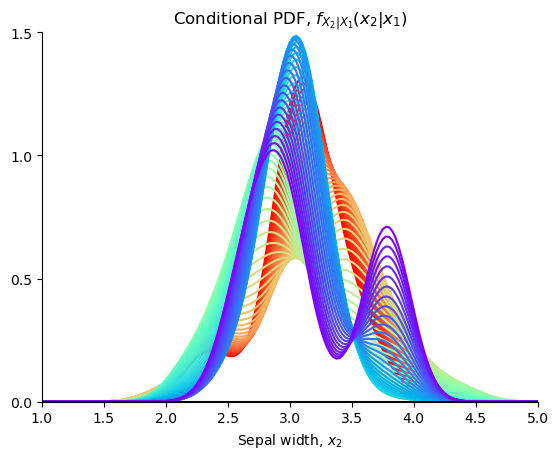

In [19]:
fig, ax = plt.subplots() # 创建2D图形对象

colors = plt.cm.rainbow_r(np.linspace(0,1,len(y_array_downsample))) # 设置颜色

for i in np.linspace(1,len(y_array_downsample),len(y_array_downsample)): # 遍历下采样后的数组
    plt.plot(x2, conditional_X2_given_X1_matrix[:, (int(i)-1)*down_step], color=colors[int(i)-1]) # 绘制PDF曲线

plt.axhline(y=0, color='k', linestyle='-') # 添加X轴水平线
ax.spines['right'].set_visible(False) # 隐藏右侧边框
ax.spines['top'].set_visible(False) # 隐藏顶部边框
ax.set_xlabel('Sepal width, $x_2$') # 设置X轴标签
ax.set_title('Conditional PDF, $f_{X_2 | X_1}(x_2 | x_1)$') # 设置标题
ax.set_xlim(xx2.min(), xx2.max()) # 设置X轴范围
ax.set_ylim(0, 1.5) # 设置Y轴范围
ax.set_yticks([0, 0.5, 1.0, 1.5]) # 设置Y轴刻度

## 条件PDF在特定的X1位置处的3D网格图

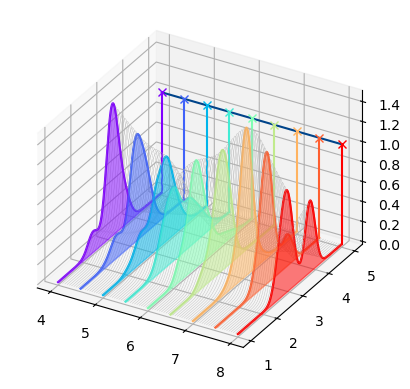

In [20]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}) # 创建3D图形对象

# 绘制条件PDF的网格线框图
ax.plot_wireframe(xx1, xx2, conditional_X2_given_X1_matrix, color=[0.7, 0.7, 0.7], linewidth=0.25, rstride=0, cstride=2)
ax.set_proj_type('ortho') # 设置正交投影

x_loc_array = np.arange(0, len(x1), 20) # 设置x1的采样位置
facecolors = cm.rainbow(np.linspace(0, 1, len(x_loc_array))) # 设置颜色

for idx in range(len(x_loc_array)): # 遍历采样位置
    x_loc = x_loc_array[idx] # 获取当前x位置
    x_idx = x1[x_loc] # 获取当前x的值
    x_i_array = x2 * 0 + x_idx # 设置X轴数组
    z_array = conditional_X2_given_X1_matrix[:, x_loc] # 获取Z轴数组
    
    ax.plot(x_i_array, x2, z_array, color=facecolors[idx, :], linewidth=1.5) # 绘制当前x位置的条件PDF曲线
    ax.add_collection3d(plt.fill_between(x2, 0 * z_array, z_array, color=facecolors[idx, :], alpha=0.3), zs=x_idx, zdir='x') # 填充条件PDF曲线区域

# 添加X2上的部分积分

ax.plot(x1, x1 * 0 + 5, partial_integral_over_x2, linewidth=1.5, color='#00448A') # 绘制X2的部分积分曲线

for i in range(len(x_loc_array)): # 遍历采样位置
    
    x_loc = x_loc_array[i] # 获取当前x位置
    x_idx = x1[x_loc] # 获取当前x的值
    
    ax.plot([x_idx, x_idx], [x2.max(), x2.max()], [0, partial_integral_over_x2[x_loc]], color=facecolors[i, :], linewidth=1.5) # 绘制部分积分的垂直线
    ax.plot(x_idx, x2.max(), partial_integral_over_x2[x_loc], marker='x', color=facecolors[i, :]) # 绘制部分积分的标记点

## Joint PDF在特定X2值处的3D绘制

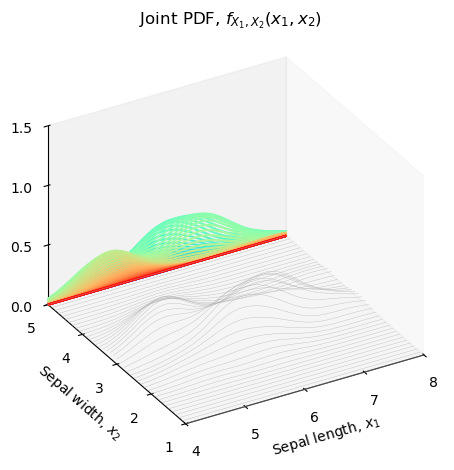

In [21]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}) # 创建3D图形对象

# 绘制联合PDF的网格线框图
ax.plot_wireframe(xx1, xx2, f_x1_x2_SM, color=[0.7, 0.7, 0.7], linewidth=0.25, rstride=4, cstride=0)
ax.contour(xx1, xx2, f_x1_x2_SM, levels=80, zdir='y', offset=xx2.max(), cmap='rainbow') # 绘制等高线图

ax.set_proj_type('ortho') # 设置正交投影

ax.set_xlabel('Sepal length, $x_1$') # 设置X轴标签
ax.set_ylabel('Sepal width, $x_2$') # 设置Y轴标签
ax.set_title('Joint PDF, $f_{X_1,X_2}(x_1,x_2)$') # 设置标题
# ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置背景颜色
# ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置背景颜色
# ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置背景颜色
ax.set_xticks([4, 5, 6, 7, 8]) # 设置X轴刻度
ax.set_yticks([1, 2, 3, 4, 5]) # 设置Y轴刻度
ax.set_zticks([0, 0.5, 1.0, 1.5]) # 设置Z轴刻度
ax.set_xlim(x1.min(), x1.max()) # 设置X轴范围
ax.set_ylim(x2.min(), x2.max()) # 设置Y轴范围
ax.set_zlim3d([0, 1.5]) # 设置Z轴范围
ax.view_init(azim=-120, elev=30) # 设置视角
plt.tight_layout() # 调整布局
ax.grid(False) # 隐藏网格线
plt.show() # 显示图形

## 特定X2值下的联合PDF的下采样投影

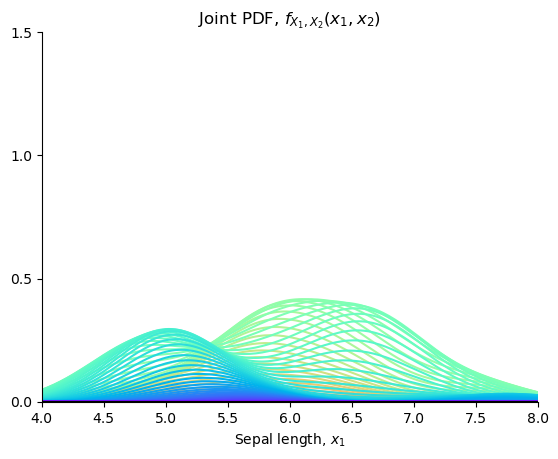

In [22]:
down_step = 2 # 设置下采样步长
array_downsample = x2[0::down_step] # 对x2进行下采样

fig, ax = plt.subplots() # 创建2D图形对象

colors = plt.cm.rainbow_r(np.linspace(0, 1, len(array_downsample))) # 设置颜色

for i in np.linspace(1, len(array_downsample), len(array_downsample)): # 遍历下采样后的数组
    plt.plot(x1, f_x1_x2_SM[(int(i)-1)*down_step, :], color=colors[int(i)-1]) # 绘制联合PDF曲线

plt.axhline(y=0, color='k', linestyle='-') # 添加X轴水平线
ax.spines['right'].set_visible(False) # 隐藏右侧边框
ax.spines['top'].set_visible(False) # 隐藏顶部边框
ax.set_xlabel('Sepal length, $x_1$') # 设置X轴标签
ax.set_title('Joint PDF, $f_{X_1,X_2}(x_1,x_2)$') # 设置标题
ax.set_xlim(xx1.min(), xx1.max()) # 设置X轴范围
ax.set_ylim(0, 1.5) # 设置Y轴范围
ax.set_yticks([0, 0.5, 1.0, 1.5]) # 设置Y轴刻度

## 计算X2的边缘分布

In [23]:
X2_df = X_df['Sepal width, $X_2$'] # 提取数据集中的X2列

KDE_X2 = sm.nonparametric.KDEUnivariate(X2_df) # 创建核密度估计对象
KDE_X2.fit(bw=0.1) # 计算核密度估计，设置带宽为0.1

f_x2_marginal = KDE_X2.evaluate(x2) # 计算X2的边缘分布

## 通过3D网格展示边缘分布

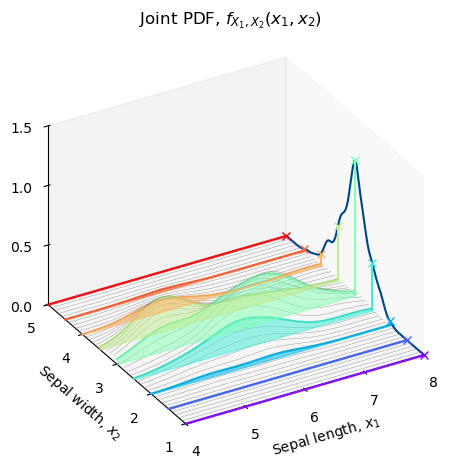

In [24]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}) # 创建3D图形对象

ax.plot_wireframe(xx1, xx2, f_x1_x2_SM, color=[0.5, 0.5, 0.5], rstride=4, cstride=0, linewidth=0.25) # 绘制联合PDF的网格线框图

ax.set_proj_type('ortho') # 设置正交投影

ax.set_xlabel('Sepal length, $x_1$') # 设置X轴标签
ax.set_ylabel('Sepal width, $x_2$') # 设置Y轴标签
ax.set_title('Joint PDF, $f_{X_1,X_2}(x_1,x_2)$') # 设置标题
ax.set_xticks([4, 5, 6, 7, 8]) # 设置X轴刻度
ax.set_yticks([1, 2, 3, 4, 5]) # 设置Y轴刻度
ax.set_zticks([0, 0.5, 1.0, 1.5]) # 设置Z轴刻度
ax.set_xlim(xx1.min(), xx1.max()) # 设置X轴范围
ax.set_ylim(xx2.min(), xx2.max()) # 设置Y轴范围
ax.set_zlim3d([0, 1.5]) # 设置Z轴范围
ax.view_init(azim=-120, elev=30) # 设置视角
plt.tight_layout() # 调整布局
ax.grid(False) # 隐藏网格线

x_loc_array = np.arange(0, len(x2), 20) # 设置x2的采样位置
facecolors = cm.rainbow(np.linspace(0, 1, len(x_loc_array))) # 设置颜色

for idx in range(len(x_loc_array)): # 遍历采样位置
    x_loc = x_loc_array[idx] # 获取当前y位置
    x_idx = x2[x_loc] # 获取当前y的值
    x_i_array = x1 * 0 + x_idx # 设置X轴数组
    z_array = f_x1_x2_SM[x_loc, :] # 获取Z轴数组
    
    ax.plot(x1, x_i_array, z_array, color=facecolors[idx, :], linewidth=1.5) # 绘制当前y位置的联合PDF曲线
    ax.add_collection3d(plt.fill_between(x1, 0 * z_array, z_array, color=facecolors[idx, :], alpha=0.3), zs=x_idx, zdir='y') # 填充联合PDF曲线区域

# 在X2方向上添加边缘分布

ax.plot(x2 * 0 + 8, x2, f_x2_marginal, linewidth=1.5, color='#00448A') # 绘制X2的边缘分布曲线

for i in range(len(x_loc_array)): # 遍历采样位置
    
    x_loc = x_loc_array[i] # 获取当前x位置
    x_idx = x2[x_loc] # 获取当前x的值
    
    ax.plot([x1.max(), x1.max()], [x_idx, x_idx], [0, f_x2_marginal[x_loc]], color=facecolors[i, :], linewidth=1.5) # 绘制边缘分布的垂直线
    ax.plot(x1.max(), x_idx, f_x2_marginal[x_loc], marker='x', color=facecolors[i, :]) # 绘制边缘分布的标记点

## 联合和边缘分布

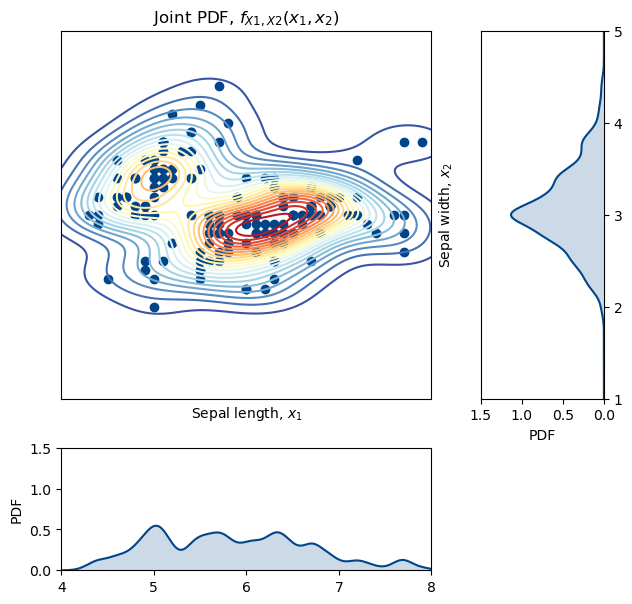

In [25]:
title_txt = 'Joint PDF, $f_{X1,X2}(x_1,x_2)$' # 设置联合PDF图的标题

# 绘制联合PDF和边缘分布
plot_joint_marginal(xx1, xx2, f_x1_x2_SM,
                    x1, f_x1_marginal,
                    x2, f_x2_marginal,
                    X1_2_df['Sepal length, $X_1$'], X1_2_df['Sepal width, $X_2$'],
                    '#00448A', title_txt) # 使用深蓝色表示

## 假设独立性下的联合PDF

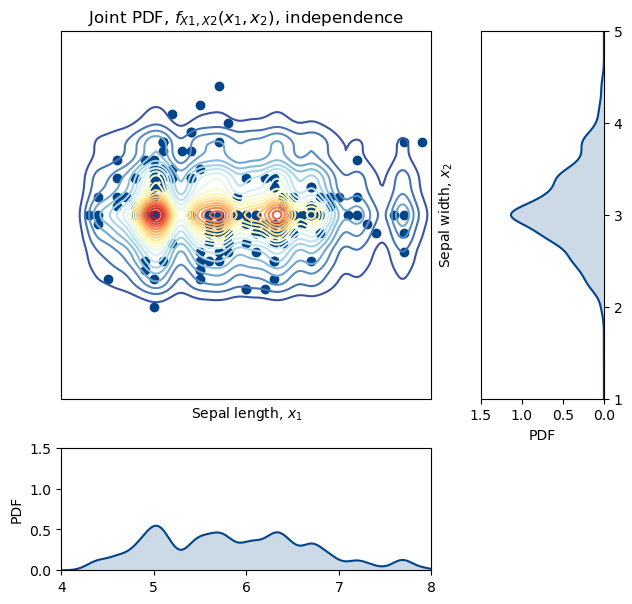

In [26]:
title_txt = 'Joint PDF, $f_{X1,X2}(x_1,x_2)$, independence' # 设置假设独立性下的联合PDF标题

# 使用X1和X2边缘分布的外积计算假设独立性下的联合PDF
plot_joint_marginal(xx1, xx2, f_x2_marginal.reshape(-1, 1) @ f_x1_marginal.reshape(1, -1),
                    x1, f_x1_marginal,
                    x2, f_x2_marginal,
                    X1_2_df['Sepal length, $X_1$'], X1_2_df['Sepal width, $X_2$'],
                    '#00448A', title_txt) # 使用深蓝色表示

## 条件概率密度函数，X2给定X1

In [27]:
delta_x = 4 / 160 # 计算delta_x，用于积分

In [28]:
# 计算X2给定X1的条件PDF
conditional_X1_given_X2_matrix = f_x1_x2_SM / (f_x1_x2_SM.sum(axis=1).reshape(-1, 1) @ np.ones((1, 161)) * delta_x)

In [29]:
# 计算条件PDF在X1上的积分，用于测试
partial_integral_over_x1 = conditional_X1_given_X2_matrix.sum(axis=1) * delta_x
# print(partial_integral_over_x1) # 输出积分结果

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [30]:
z_height = 1.5 # 设置Z轴高度
title_txt = 'Conditional PDF, $f_{X_1 | X_2}(x_1 | x_2)$' # 设置条件PDF标题

## 绘制条件PDF的3D表面图

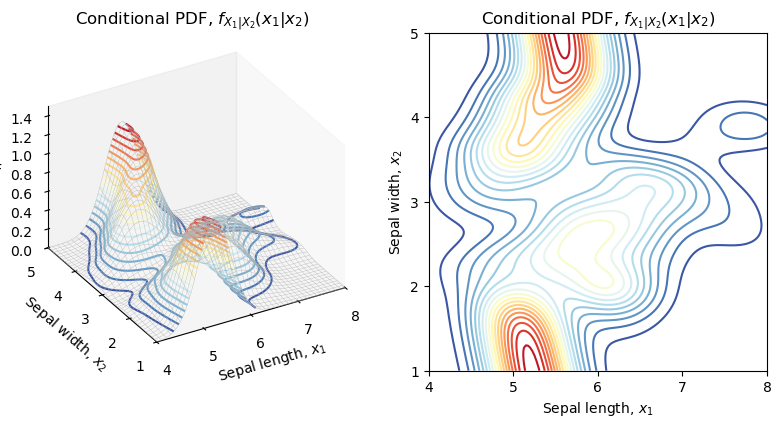

In [31]:
plot_surface(xx1, xx2, conditional_X1_given_X2_matrix, z_height, title_txt)

## 条件X1给定X2的网格图

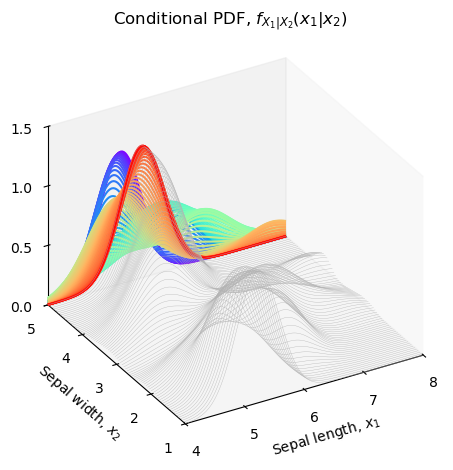

In [32]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}) # 创建3D图形对象

# 绘制条件PDF的网格线框图
ax.plot_wireframe(xx1, xx2, conditional_X1_given_X2_matrix, color=[0.7, 0.7, 0.7], linewidth=0.25, rstride=2, cstride=0)

# 添加等高线图
ax.contour(xx1, xx2, conditional_X1_given_X2_matrix, levels=80, zdir='y', offset=xx2.max(), cmap='rainbow')

ax.set_proj_type('ortho') # 设置正交投影

ax.set_xlabel('Sepal length, $x_1$') # 设置X轴标签
ax.set_ylabel('Sepal width, $x_2$') # 设置Y轴标签
ax.set_title('Conditional PDF, $f_{X_1 | X_2}(x_1 | x_2)$') # 设置图形标题
# ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置X轴面板颜色
# ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置Y轴面板颜色
# ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置Z轴面板颜色
ax.set_xticks([4, 5, 6, 7, 8]) # 设置X轴刻度
ax.set_yticks([1, 2, 3, 4, 5]) # 设置Y轴刻度
ax.set_zticks([0, 0.5, 1.0, 1.5]) # 设置Z轴刻度
ax.set_xlim(x1.min(), x1.max()) # 设置X轴范围
ax.set_ylim(x2.min(), x2.max()) # 设置Y轴范围
ax.set_zlim3d([0, 1.5]) # 设置Z轴范围
ax.view_init(azim=-120, elev=30) # 设置视角
ax.grid(False) # 隐藏网格线
plt.tight_layout() # 调整布局
plt.show() # 显示图形

## 投影下采样后的条件X1给定X2的表面

In [33]:
down_step = 2 # 下采样步长
y_array_downsample = x2[0::down_step] # 对x2进行下采样

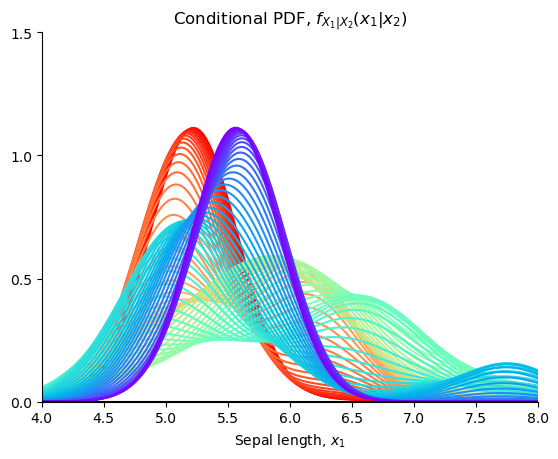

In [34]:
fig, ax = plt.subplots() # 创建2D图形对象

colors = plt.cm.rainbow_r(np.linspace(0, 1, len(y_array_downsample))) # 设置颜色

# 遍历下采样后的y数组，绘制每个y位置的条件PDF曲线
for i in np.linspace(1, len(y_array_downsample), len(y_array_downsample)):
    plt.plot(x1, conditional_X1_given_X2_matrix[(int(i)-1)*down_step, :], color=colors[int(i)-1])

plt.axhline(y=0, color='k', linestyle='-') # 添加X轴水平线
ax.spines['right'].set_visible(False) # 隐藏右侧边框
ax.spines['top'].set_visible(False) # 隐藏顶部边框
ax.set_xlabel('Sepal length, $x_1$') # 设置X轴标签
ax.set_title('Conditional PDF, $f_{X_1 | X_2}(x_1 | x_2)$') # 设置标题
ax.set_xlim(xx1.min(), xx1.max()) # 设置X轴范围
ax.set_ylim(0, 1.5) # 设置Y轴范围
ax.set_yticks([0, 0.5, 1.0, 1.5]) # 设置Y轴刻度

## 条件X1给定特定X2值的网格图

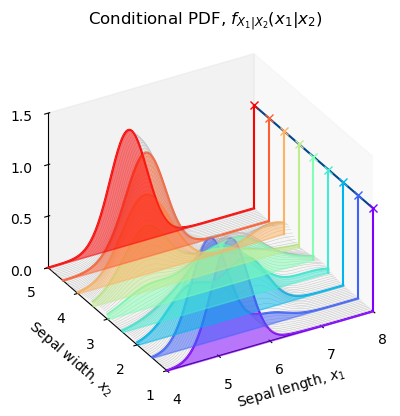

<Figure size 640x480 with 0 Axes>

In [35]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}) # 创建3D图形对象

# 绘制条件PDF的网格线框图
ax.plot_wireframe(xx1, xx2, conditional_X1_given_X2_matrix, color=[0.7, 0.7, 0.7], linewidth=0.25, rstride=2, cstride=0)

ax.set_proj_type('ortho') # 设置正交投影

# 设置X2的采样位置和颜色
x_loc_array = np.arange(0, len(x1), 20)
facecolors = cm.rainbow(np.linspace(0, 1, len(x_loc_array)))

# 遍历采样位置，绘制每个位置的条件PDF曲线和区域填充
for idx in range(len(x_loc_array)):
    x_loc = x_loc_array[idx]
    x_idx = x2[x_loc]
    x_i_array = x1 * 0 + x_idx
    z_array = conditional_X1_given_X2_matrix[x_loc, :]
    
    ax.plot(x1, x_i_array, z_array, color=facecolors[idx, :], linewidth=1.5) # 绘制条件PDF曲线
    ax.add_collection3d(plt.fill_between(x1, 0 * z_array, z_array, color=facecolors[idx, :], alpha=0.3), zs=x_idx, zdir='y') # 填充区域

# 在X2方向上添加边缘分布曲线
ax.plot(x1 * 0 + 8, x2, partial_integral_over_x1, linewidth=1.5, color='#00448A') # 绘制条件积分曲线

# 遍历采样位置，绘制垂直于边缘分布的线和标记
for i in range(len(x_loc_array)):
    x_loc = x_loc_array[i]
    x_idx = x2[x_loc]
    
    ax.plot([x1.max(), x1.max()], [x_idx, x_idx], [0, partial_integral_over_x1[x_loc]], color=facecolors[i, :], linewidth=1.5) # 绘制垂直线
    ax.plot(x1.max(), x_idx, partial_integral_over_x1[x_loc], marker='x', color=facecolors[i, :]) # 绘制标记点

ax.set_xlabel('Sepal length, $x_1$') # 设置X轴标签
ax.set_ylabel('Sepal width, $x_2$') # 设置Y轴标签
ax.set_title('Conditional PDF, $f_{X_1 | X_2}(x_1 | x_2)$') # 设置图形标题
# ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置X轴面板颜色
# ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置Y轴面板颜色
# ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0)) # 设置Z轴面板颜色
ax.set_xticks([4, 5, 6, 7, 8]) # 设置X轴刻度
ax.set_yticks([1, 2, 3, 4, 5]) # 设置Y轴刻度
ax.set_zticks([0, 0.5, 1.0, 1.5]) # 设置Z轴刻度
ax.set_xlim(x1.min(), x1.max()) # 设置X轴范围
ax.set_ylim(x2.min(), x2.max()) # 设置Y轴范围
ax.set_zlim3d([0, 1.5]) # 设置Z轴范围
ax.view_init(azim=-120, elev=30) # 设置视角
ax.grid(False) # 隐藏网格线
plt.show() # 显示图形
plt.tight_layout() # 调整布局